In [3]:
from utils import *
from fastai2.vision.all import *

In [4]:
path = untar_data(URLs.PASCAL_2007)

In [5]:
path.ls()

(#8) [Path('/home/jayajasodani/.fastai/data/pascal_2007/test.json'),Path('/home/jayajasodani/.fastai/data/pascal_2007/train.csv'),Path('/home/jayajasodani/.fastai/data/pascal_2007/train'),Path('/home/jayajasodani/.fastai/data/pascal_2007/test.csv'),Path('/home/jayajasodani/.fastai/data/pascal_2007/test'),Path('/home/jayajasodani/.fastai/data/pascal_2007/valid.json'),Path('/home/jayajasodani/.fastai/data/pascal_2007/train.json'),Path('/home/jayajasodani/.fastai/data/pascal_2007/segmentation')]

In [6]:
Path('/home/jayajasodani/.fastai/').ls()

(#7) [Path('/home/jayajasodani/.fastai/2'),Path('/home/jayajasodani/.fastai/0'),Path('/home/jayajasodani/.fastai/1'),Path('/home/jayajasodani/.fastai/config.yml'),Path('/home/jayajasodani/.fastai/data'),Path('/home/jayajasodani/.fastai/archive'),Path('/home/jayajasodani/.fastai/3')]

In [7]:
df=pd.read_csv(path/'train.csv')
df.head(10)

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
5,000017.jpg,person horse,False
6,000019.jpg,cat,True
7,000020.jpg,car,True
8,000021.jpg,dog person,True
9,000023.jpg,bicycle person,False


In [8]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [9]:
df.iloc[0,:]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [10]:
dblock = DataBlock()
dsets = dblock.datasets(df)

In [11]:
len(dsets.train), len(dsets.valid) #DataBlock splits 20% train into validation set

(4009, 1002)

In [12]:
x,y = dsets.train[0]             #x and y have same data 
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [13]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y= lambda r: r['labels']) #need to define input & target for DataBlock
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [14]:
def get_x(r): return path/'train'/r['fname'] #path changed from 'train.csv' to 'train' to capture the actual image
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/home/jayajasodani/.fastai/data/pascal_2007/train/002549.jpg'),
 ['tvmonitor'])

In [15]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock), get_x = get_x, get_y = get_y) #label output is multicategory
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x325,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

In [16]:
idxs = torch.where(dsets.train[0][1]==1.)[0] #first training sample train[0] has label train[0][1]. If it is equal to '1' then take the first of that value
dsets.train.vocab[idxs]   #'vocab' converts 

(#1) ['train']

In [17]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()    # indexes where column 'is valid' is FALSE. Convert indexes to list
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [18]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter = splitter,
                   get_x = get_x,
                   get_y = get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
                   
dls = dblock.dataloaders(df)        # datasets(df) changed to dataloaders(df)

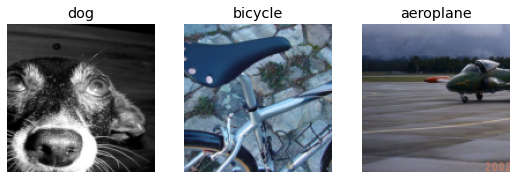

In [19]:
dls.show_batch(nrows=1, ncols=3)

In [20]:
learn = cnn_learner(dls, resnet18)

In [21]:
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [22]:
activs[0]

tensor([ 0.4153,  1.2974, -2.9310,  1.3063, -0.6814, -1.7772,  0.8123, -0.4988, -1.6027,  1.3562,  1.2609,  0.0103,  2.3019, -0.4606, -0.4662,  0.6359, -3.2023, -0.8144, -3.8843, -0.8441],
       grad_fn=<SelectBackward>)

In [23]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [24]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(1.0954, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [25]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.937558,0.704015,0.234422,05:21
1,0.816344,0.550464,0.298048,05:19
2,0.599506,0.195933,0.830259,05:17
3,0.359844,0.126048,0.939920,05:19


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.132535,0.118039,0.943984,06:36
1,0.116747,0.107582,0.952191,06:37
2,0.096873,0.103619,0.952132,06:36


In [26]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10361947864294052,0.9310558438301086]

In [27]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10361947864294052,0.9432469606399536]

In [28]:
preds,targs = learn.get_preds()

In [29]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9569)

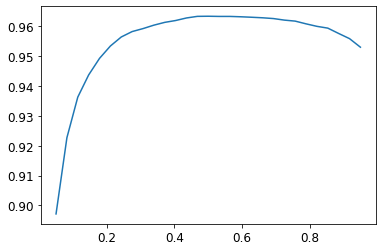

In [30]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);